## Logistic Regression - __версия 3__

Disclaimer:

Изначально я взял данные и не сильно проверял что внутри, оказалось, текст внутри (title, description, keywords) на разных языках, очевидно, что модель не смогла найти соответсвия, поэтому в данной версии планирую исплользовать multilingual text classifier c эмбедингами вместо TF-IDF для признаков на разных языках.

Также в данных отсутствоали негативные примеры, типа совпадения были match / weak_match / related.
В данной версии добавлен no_match.

Так же планирую использовать большую выборку - 10к записей.

Классификация та же самая - типа совпадения RFQ–Supplier (match, weak_match, related, no_match) на основе логистической регрессии.

---
## 1. Импорты и настройки


In [17]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from transformers import pipeline
from sentence_transformers import SentenceTransformer

---
## 2. Загрузка данных

In [18]:
data_path = Path("dataset/dataset_10k.csv")
df = pd.read_csv(data_path)

print("Форма датасета:", df.shape)
print("Колонки:", df.columns)

Форма датасета: (10000, 15)
Колонки: Index(['rfq_id', 'rfq_title', 'rfq_description', 'quantity',
       'delivery_location', 'rfq_supplier_types', 'supplier_name',
       'supplier_country', 'distribution_area', 'supplier_description',
       'supplier_types', 'products', 'product_categories', 'keywords',
       'match_type'],
      dtype='object')


---
## 3. Предобработка

Очистка полей в формате PostgreSQL-массивов (фигурные скобки), подсчёт пропусков, заполнение пропусков в текстовых полях, формирование признаков `rfq_text` и `supplier_text`.

In [19]:
def clean_array_field(s: str) -> str:
    if pd.isna(s):
        return ""
   
    s = str(s).strip()
    if s.startswith("{") and s.endswith("}"):
        s = s[1:-1]

    return s.replace(",", ", ")

# Колонки в формате массива
array_columns = [
    "rfq_supplier_types", "supplier_types", "products", "product_categories", "keywords"
]
for col in array_columns:
    if col in df.columns:
        df[col] = df[col].apply(clean_array_field)


df.head()

,rfq_id,rfq_title,rfq_description,quantity,delivery_location,rfq_supplier_types,supplier_name,supplier_country,distribution_area,supplier_description,supplier_types,products,product_categories,keywords,match_type
0,93c75bb7-1545-4279-aada-6d66b9c9e62e,electric kick scooters e-scooters,New family startup; looking for: e-scooter for...,10,"Heilbronn, Deutschland","PRODUCTION, WHOLESALER, DISTRIBUTION",Yatdim GmbH,DE,international,Yatdim GmbH – Your Partner for E-Mobility Whol...,"Distribution, Production, Wholesaler",E-Bike BURCHDA RX80 fully suspended mountain b...,Vehicles,"Burchda RX80 Elektrofahrrad, E Mountainbike 26...",weak_match
1,93c75bb7-1545-4279-aada-6d66b9c9e62e,electric kick scooters e-scooters,New family startup; looking for: e-scooter for...,10,"Heilbronn, Deutschland","PRODUCTION, WHOLESALER, DISTRIBUTION",Erler Mobile GmbH,DE,europe,Erler Mobile produces electric scooters and el...,"Production, Distribution, Wholesaler","Industrieroller COLLY 1, Industrieroller COLLY...",Fahrzeuge,"Industrieroller, Transportroller für Personen,...",related
2,93c75bb7-1545-4279-aada-6d66b9c9e62e,electric kick scooters e-scooters,New family startup; looking for: e-scooter for...,10,"Heilbronn, Deutschland","PRODUCTION, WHOLESALER, DISTRIBUTION",Yatdim GmbH,DE,international,Yatdim GmbH – Your Partner for E-Mobility Whol...,"Wholesaler, Production, Distribution","""E-Bike Onesport OT16 Klappbares Elektrofahrra...",Fahrzeuge,"OneSport OT16 Elektrofahrrad, E Bike klappbar ...",related
3,93c75bb7-1545-4279-aada-6d66b9c9e62e,electric kick scooters e-scooters,New family startup; looking for: e-scooter for...,10,"Heilbronn, Deutschland","PRODUCTION, WHOLESALER, DISTRIBUTION",Sauter Engineering + Design GmbH,DE,international,Sauter Engineering + Design GmbH stands for ta...,Service,"Product Development - Design, Product Developm...","""Planning, engineering and development""","""Product Development "", Produktentwicklung, De...",no_match
4,93c75bb7-1545-4279-aada-6d66b9c9e62e,electric kick scooters e-scooters,New family startup; looking for: e-scooter for...,10,"Heilbronn, Deutschland","PRODUCTION, WHOLESALER, DISTRIBUTION",EVENTTRUCK MASTERS,BE,europe,Event Truck Masters is a company specializing ...,"Wholesaler, Distribution","""FOODTRUCKS for sale and rent, suitable for a...",Vehicles,"Foordtrucks, Food trucks, Location de food tru...",no_match


In [11]:
# Количество пропусков по колонкам до заполнения
nan_counts = df.isna().sum()
print("Пропуски по колонкам (до заполнения):")
for col in df.columns:
    if nan_counts[col] > 0:
        print(f"  {col}: {nan_counts[col]}")

Пропуски по колонкам (до заполнения):
  distribution_area: 1788
  supplier_description: 471


In [12]:
# Заполняем пропуски в текстовых полях пустой строкой
text_columns = [
    "rfq_title", "rfq_description", "delivery_location", "quantity",
    "rfq_supplier_types", "supplier_name", "supplier_country", "distribution_area",
    "supplier_description", "supplier_types", "products", "product_categories", "keywords"
]
for col in text_columns:
    if col in df.columns:
        df[col] = df[col].fillna("").astype(str)

In [21]:
# Текстовые признаки: rfq_text (RFQ), supplier_text (поставщик)
df["rfq_text"] = (
    df["rfq_title"].astype(str) + " "
    + df["rfq_description"].astype(str) + " "
    + df["delivery_location"].astype(str) + " "
    + df["quantity"].astype(str) + " "
    + df["rfq_supplier_types"].astype(str)
)

# supplier_text без multilingual полей (products, product_categories, keywords)
# — они будут обработаны отдельно через multilingual sentence embeddings
df["supplier_text"] = (
    df["supplier_name"].astype(str) + " "
    + df["supplier_description"].astype(str) + " "
    + df["distribution_area"].astype(str) + " "
    + df["supplier_country"].astype(str) + " "
    + df["supplier_types"].astype(str)
)

# Объединяем multilingual поля для получения эмбеддингов
df["multilingual_text"] = (
    df["products"].astype(str) + " "
    + df["product_categories"].astype(str) + " "
    + df["keywords"].astype(str)
)

df[["supplier_text", "multilingual_text"]].head(10)

,supplier_text,multilingual_text
0,Yatdim GmbH Yatdim GmbH – Your Partner for E-M...,E-Bike BURCHDA RX80 fully suspended mountain b...
1,Erler Mobile GmbH Erler Mobile produces electr...,"Industrieroller COLLY 1, Industrieroller COLLY..."
2,Yatdim GmbH Yatdim GmbH – Your Partner for E-M...,"""E-Bike Onesport OT16 Klappbares Elektrofahrra..."
3,Sauter Engineering + Design GmbH Sauter Engine...,"Product Development - Design, Product Developm..."
4,EVENTTRUCK MASTERS Event Truck Masters is a co...,"""FOODTRUCKS for sale and rent, suitable for a..."
5,KDE Handel GmbH We see ourselves as a link bet...,QSTRADE Unternehmensberatung – Ihr Partner für...
6,"Werner Krauter GmbH Manufacture, distribution ...",Drehstrom Kurzschlussläufer Motor - mit Bremse...
7,Waldbike GmbH & Co. KG Waldbike is a company t...,"""E-Bike Leasing & Dienstrad-Finanzierung von W..."
8,PATCOM PAT COM – Supplier of Stock and Clearan...,Extra Virgin Olive Oil - Glass Bottles or PET ...
9,Feeser GmbH Manufacturer and wholesale for die...,"""Feeser Dieselstromerzeuger P-D6-S/400 ST "", F..."


---
## 3.1. Multilingual Embeddings для products, product_categories, keywords

Поля `products`, `product_categories`, `keywords` содержат текст на разных языках (DE, EN, и др.).
TF-IDF не может сопоставить слова на разных языках (например, "Schrauben" и "screws").

Используем **paraphrase-multilingual-MiniLM-L12-v2** — предобученную multilingual sentence transformer модель, которая отображает тексты на 50+ языках в единое 384-мерное пространство эмбеддингов. Это позволяет модели находить семантическое сходство между текстами независимо от языка.

In [ ]:
st_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

multilingual_embeddings = st_model.encode(
    df["multilingual_text"].tolist(),
    show_progress_bar=True,
    batch_size=64,
)

# Добавляем эмбеддинги как отдельные колонки
emb_cols = [f"ml_emb_{i}" for i in range(multilingual_embeddings.shape[1])]
df[emb_cols] = pd.DataFrame(multilingual_embeddings, index=df.index)

print(f"Модель: paraphrase-multilingual-MiniLM-L12-v2")
print(f"Размерность эмбеддингов: {multilingual_embeddings.shape[1]}")
print(f"Добавлено {len(emb_cols)} колонок с эмбеддингами")

---
## 4. Разбиение на обучающую, валидационную и тестовую выборки (60 / 20 / 20)

Используется **GroupShuffleSplit** по ключу `rfq_id`: все строки одного RFQ попадают в одну выборку. Сначала отделяем 60% групп в train и 40% во временную выборку; затем делим временную пополам — 20% validation, 20% test.

In [29]:
y = df["match_type"]
groups = df["rfq_id"]
feature_columns = ["rfq_text", "supplier_text"] + emb_cols

# 60% train, 40% временная выборка (будущие val + test)
gss1 = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=42)
train_idx, temp_idx = next(gss1.split(df, y, groups))

# Из 40% временной: половина validation, половина test (20% и 20% от всего)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=43)
val_idx, test_idx = next(gss2.split(df.iloc[temp_idx], y.iloc[temp_idx], groups.iloc[temp_idx]))
val_idx = np.array(temp_idx)[val_idx]
test_idx = np.array(temp_idx)[test_idx]

X_train = df.loc[train_idx, feature_columns]
y_train = y.iloc[train_idx]
X_val = df.loc[val_idx, feature_columns]
y_val = y.iloc[val_idx]
X_test = df.loc[test_idx, feature_columns]
y_test = y.iloc[test_idx]

print("Размер обучающей выборки (train):", len(X_train))
print("Размер валидационной выборки (validation):", len(X_val))
print("Размер тестовой выборки (test):", len(X_test))

Размер обучающей выборки (train): 5878
Размер валидационной выборки (validation): 2148
Размер тестовой выборки (test): 1974


---
## 5. Модель и обучение

Конвейер: **ColumnTransformer** с тремя блоками признаков:
1. **TfidfVectorizer** по `rfq_text`
2. **TfidfVectorizer** по `supplier_text`
3. **Multilingual embeddings** (384 dim) — passthrough-признаки из модели paraphrase-multilingual-MiniLM-L12-v2 для полей `products`, `product_categories`, `keywords`

Классификатор: **LogisticRegression** с `class_weight='balanced'` для учёта дисбаланса классов.

In [25]:
column_transformer = ColumnTransformer(
    [
        ("rfq_tfidf", TfidfVectorizer(), "rfq_text"),
        ("supplier_tfidf", TfidfVectorizer(), "supplier_text"),
        ("ml_embeddings", "passthrough", emb_cols),
    ],
    remainder="drop",
)

pipeline = Pipeline([
    ("features", column_transformer),
    ("clf", LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")),
])

pipeline.fit(X_train, y_train)

# Предсказания: на validation (для подбора гиперпараметров) и на test (финальная оценка)
y_pred_val = pipeline.predict(X_val)
y_pred = pipeline.predict(X_test)

---
## 6. Оценка качества и визуализация

In [26]:
print("Validation (accuracy):", round(accuracy_score(y_val, y_pred_val), 4))
print()
print("Test — classification report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Test — accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nConfusion matrix (test):")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Validation (accuracy): 0.5321

Test — classification report:
              precision    recall  f1-score   support

       match       0.54      0.35      0.43       609
    no_match       0.71      0.75      0.73      1173
     related       0.09      0.19      0.12        81
  weak_match       0.10      0.17      0.13       111

    accuracy                           0.57      1974
   macro avg       0.36      0.37      0.35      1974
weighted avg       0.60      0.57      0.58      1974

Test — accuracy: 0.5735

Confusion matrix (test):
[[213 261  58  77]
 [143 885  64  81]
 [ 13  46  15   7]
 [ 23  47  22  19]]


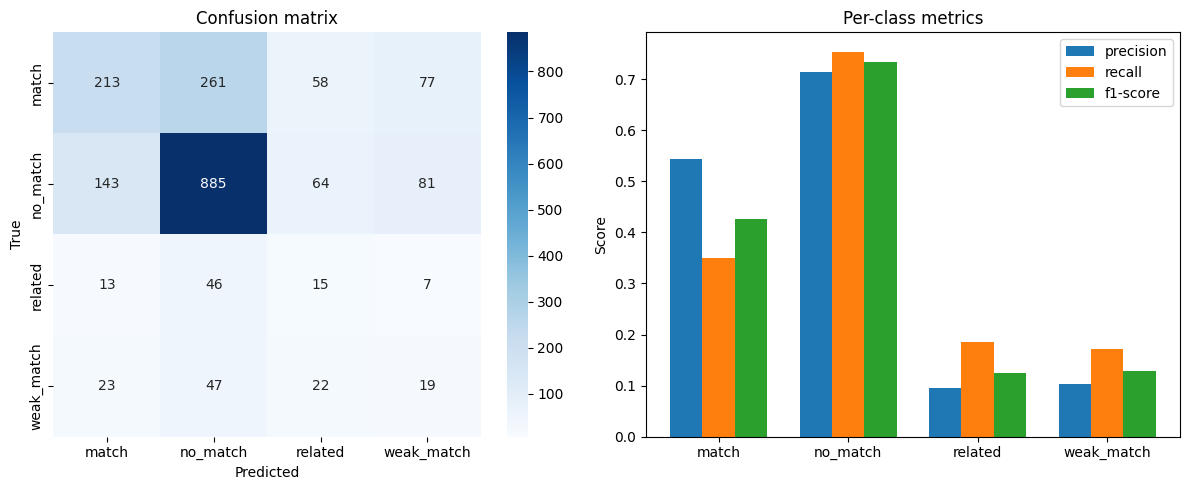

In [27]:
labels = sorted(y.unique())
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Матрица ошибок
sns.heatmap(
    cm, xticklabels=labels, yticklabels=labels, annot=True, fmt="d",
    cmap="Blues", ax=axes[0]
)
axes[0].set_title("Confusion matrix")
axes[0].set_ylabel("True")
axes[0].set_xlabel("Predicted")

# Метрики по классам
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
metrics = ["precision", "recall", "f1-score"]
x = np.arange(len(labels))
width = 0.25
for i, m in enumerate(metrics):
    vals = [report[l].get(m, 0) for l in labels]
    axes[1].bar(x + i * width, vals, width, label=m)
    
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(labels)
axes[1].set_ylabel("Score")
axes[1].set_title("Per-class metrics")
axes[1].legend()

plt.tight_layout()
plt.show()

## Выводы

### Что изменилось в версии 3

**Multilingual embeddings**: поля `products`, `product_categories`, `keywords` содержат текст на разных языках (DE, EN и др.).
В предыдущих версиях TF-IDF не мог сопоставить слова на разных языках (например, "Schrauben" ≠ "screws").

В данной версии:
- Использована модель **paraphrase-multilingual-MiniLM-L12-v2** для получения 384-мерных семантических эмбеддингов полей `products`, `product_categories`, `keywords`.
- Эти эмбеддинги добавлены как дополнительные признаки к TF-IDF для `rfq_text` и `supplier_text`.
- Multilingual модель отображает тексты на 50+ языках в единое векторное пространство, что позволяет находить семантическое сходство независимо от языка.
- Добавлен класс **no_match** (негативные примеры), ранее отсутствовавший в данных.
- Использована большая выборка — **10к записей** (ранее 1к).

### Анализ текущих результатов

**Test accuracy: 57.4%** — формально ниже, чем в v2 (61.5%), но задача стала значительно сложнее:
- Добавлен 4-й класс (no_match), что увеличивает пространство ошибок.
- Выборка увеличена в 10 раз (10к vs 1к записей), данные более разнообразные.

**no_match (precision=71%, recall=75%, f1=0.73)** — лучший класс. Модель хорошо отличает полное несовпадение от любых совпадений. Это ожидаемо — no_match семантически наиболее далёк от остальных классов.

**match (precision=54%, recall=35%, f1=0.43)** — модель стала осторожнее с предсказанием match. Из 609 реальных match только 213 предсказаны верно, а 261 ошибочно отнесены к no_match. Это говорит о том, что граница между match и no_match размыта для модели.

**related (precision=9%, recall=19%, f1=0.12)** — прогресс по сравнению с v2 (было 0%/0%). Модель начала хотя бы частично распознавать этот класс. Однако из 81 related только 15 предсказаны верно — класс по-прежнему слабо выделяется.

**weak_match (precision=10%, recall=17%, f1=0.13)** — аналогично related: recall вырос (17% vs 9%), но precision упал (10% vs 13%). Из 111 weak_match верно предсказано лишь 19.

### Ключевые наблюдения

1. **no_match доминирует** — с 1173 примерами (59% выборки) это самый представленный класс, и модель научилась его хорошо предсказывать.
2. **match vs no_match — основная путаница**: 261 match ошибочно классифицированы как no_match, и 143 no_match — как match. Эти два класса наиболее трудно разделимы.
3. **Миноритарные классы (related, weak_match)** — по-прежнему плохо предсказываются из-за малого числа примеров (81 и 111 соответственно) и семантической близости к match/no_match.
4. **Multilingual embeddings дали эффект** — ранее related вообще не распознавался (0/0), теперь recall=19%. Модель начала улавливать кросс-языковое семантическое сходство.